<a href="https://colab.research.google.com/github/ANASS19/AI/blob/main/Lab_5_Transfer_Learning_and_Self_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5 - Transfer Learning and Self-Supervised Learning

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
project_path = "/content/gdrive/MyDrive/ColabData/AmID"

import sys
sys.path.append('/content/gdrive/MyDrive/ColabData')

import pickle
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, Conv1D, MaxPooling1D, GlobalMaxPool1D, UpSampling1D, Reshape
from tensorflow.keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Mounted at /content/gdrive


# Transfer Learning

In [ ]:
f = open(f"{project_path}/Lab1/pamap2_2_seconds_0_overlap.txt", "rb")
pamap2 = pickle.load(f)

samples = np.concatenate((pamap2["accelerometer_samples"], pamap2["gyroscope_samples"]), axis=2)
labels, users = pamap2["labels"], pamap2["subjects"]

del pamap2

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

Samples: (9628, 200, 6)
Labels: (9628,)
Users: (9628,)


In [ ]:
activities_map = {
     0: "other",
     1: "lying",
     2: "sitting",
     3: "standing",
     4: "walking",
     5: "running",
     6: "cycling",
     7: "Nordic walking",
     9: "watching TV",
    10: "computer work",
    11: "car driving",
    12: "ascending stairs",
    13: "descending stairs",
    16: "vacuum cleaning",
    17: "ironing",
    18: "folding laundry",
    19: "house cleaning",
    20: "playing soccer",
    24: "rope jumping"
}

print(labels[0])
labels = np.array([activities_map[lab] for lab in list(labels)])
print(labels[0])

1
lying


In [ ]:
to_keep = np.where((labels != "rope jumping") & (labels != "Nordic walking") & (labels != "vacuum cleaning") & (labels != "ironing"))[0]

samples, labels, users = samples[to_keep], labels[to_keep], users[to_keep]

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

classes = sorted(list(set(labels)))
print("Classes:", classes)

Samples: (6397, 200, 6)
Labels: (6397,)
Users: (6397,)
Classes: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']


In [ ]:
enc = OneHotEncoder()
ohe_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print(f"Original list of labels: {classes}")

print(f'Example of original label: {labels[3000]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels[3000]}")

Original list of labels: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']
Example of original label: cycling
...and the corresponding one-hot encoded version: [0. 1. 0. 0. 0. 0. 0. 0.]


<br>

We simulate a scenario in which we want to recognize the activities of a new subject, but we don't have many labeled data.

Fortunately, we had already provided our framework to other subjects, and we have much more labeled data of them. The only problem is that we never collected data about the activity "standing", but now we want to recognize it for the new subject.

What can we do?

We split the dataset into:
* **Pre-train set**: labeled data from the subjects that already use our framework, without the Standing activity
* **Fine-tuning set**: low amount of labeled data from the new subject, including the Standing activity
* **Test set**: labeled data from the new subject, useful to validate our transfer learning solution

Then we will compare two models:
1. **Baseline**: a method that relies only on the low amount of labeled data from the new subject (i.e., the fine-tuning set)
2. **Transfer Learning method**: a method pre-trained on the pre-train set (without the Standing activity), and fine-tuned on the fine-tuning set (with the Standing activity). This method transfers its knowledge about the previous subjects to the new subject

In [ ]:
pre_train = np.where((users != 101) & (labels != "standing"))[0]
fine_tuning = np.where((users == 101))[0]

# from the data of the new subject, we use 5% for fine-tuning and 95% for test
fine_tuning, test, _, _ = train_test_split(fine_tuning, labels[fine_tuning], test_size=0.95, random_state=0)

print(f"Pre-train size: {len(pre_train)} ({len(pre_train)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(pre_train)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[pre_train])))}")
print(f"Fine-tuning size: {len(fine_tuning)} ({len(fine_tuning)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(fine_tuning)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[fine_tuning])))}")
print(f"Test size: {len(test)} ({len(test)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%). Activities: {sorted(list(set(labels[test])))}")

Pre-train size: 4715 (84.82%) -> 157.17 minutes of data. Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'walking']
Fine-tuning size: 42 (0.76%) -> 1.40 minutes of data. Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']
Test size: 802 (14.43%). Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

## Baseline

In [ ]:
def baseline(num_classes=len(classes)):
  input = Input((200, 6), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="baseline")

  return model

In [ ]:
model = baseline()
print(model.summary())

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling1d (Glob  (None, 96)                0  


Creating the model...

Training...
Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 2.1535 - accuracy: 0.1081 - val_loss: 1.7511 - val_accuracy: 0.2000
Epoch 2/200
1/1 [==============================] - 0s 36ms/step - loss: 1.5921 - accuracy: 0.3514 - val_loss: 1.5269 - val_accuracy: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 1.3925 - accuracy: 0.4054 - val_loss: 1.2658 - val_accuracy: 0.4000
Epoch 4/200
1/1 [==============================] - 0s 38ms/step - loss: 1.2338 - accuracy: 0.4865 - val_loss: 1.0154 - val_accuracy: 0.8000
Epoch 5/200
1/1 [==============================] - 0s 36ms/step - loss: 1.1114 - accuracy: 0.6486 - val_loss: 0.7927 - val_accuracy: 1.0000
Epoch 6/200
1/1 [==============================] - 0s 35ms/step - loss: 1.0108 - accuracy: 0.6486 - val_loss: 0.6110 - val_accuracy: 1.0000
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 0.9111 - accuracy: 0.6486 - val_loss: 0.4751 - val_acc

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

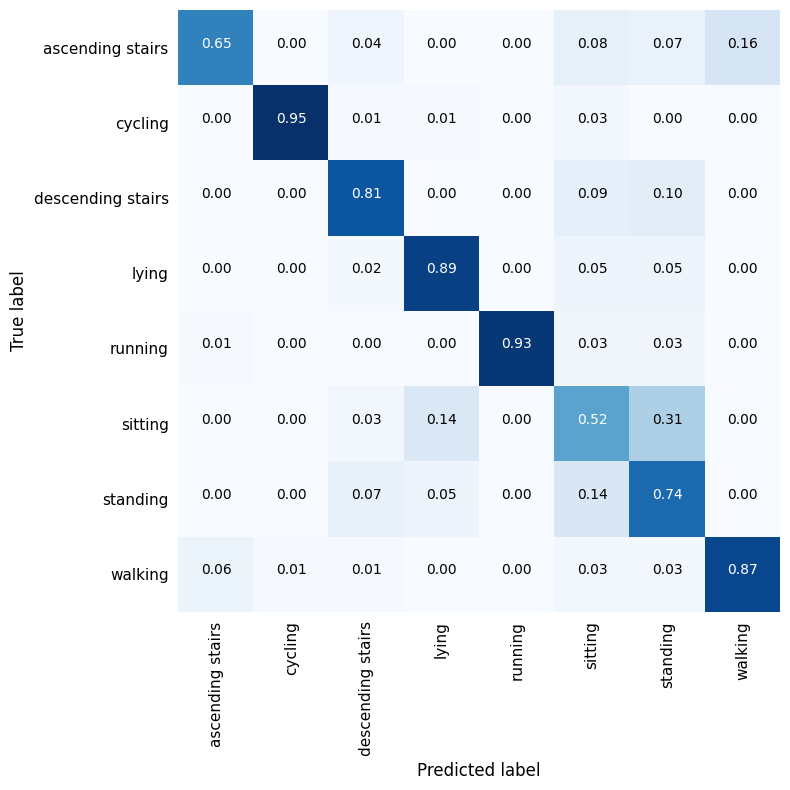

In [ ]:
# early stopping: if for 5 consecutive epochs the loss on the validation set does not improve, we stop the training process and restore the weights of the best model
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("\nCreating the model...")
model = baseline()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nTraining...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

## Transfer Learning method

This will be our transfer learning pipeline:

1. **Pre-training**: pre-train a classifier on the pre-train set without the Standing activity

2. **Fine-tuning**: take the layers of the pre-trained model in charge of extracting features, add new trainable layers on top of them, and fine tune the model on the fine-tuning set. The new layers will learn how to turn the old features into predictions for the new subject (including the Standing activity). The goal is to adapt the model to the specific characteristics of the target problem while retaining the general knowledge learned during pretraining. This step can be implemented in two different ways: by freezing or unfreezing the feature extraction layers. If we unfreeze the layers, it is typically better to user a very low learning rate to avoid changing unsafely the weights of the feature extraction layers

<br>

Pre-training

In [ ]:
enc = OneHotEncoder()
ohe_labels_pre_train = enc.fit_transform(labels[pre_train].reshape(-1,1)).toarray()

classes_pre_train = sorted(list(set(labels[pre_train])))
print(f"Original list of labels: {classes_pre_train}")

print(f'Example of original label: {labels[pre_train][0]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels_pre_train[0]}")

Original list of labels: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'walking']
Example of original label: lying
...and the corresponding one-hot encoded version: [0. 0. 0. 1. 0. 0. 0.]


In [ ]:
def pre_train_classifier(num_classes=len(classes_pre_train)):
  input = Input((200, 6), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="pre_train_classifier")

  return model

In [ ]:
model = pre_train_classifier()
print(model.summary())

Model: "pre_train_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling1d (Glob  (None, 96)       

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 200
batch_size = 128

print("Creating the model...")
pre_trained_model = pre_train_classifier()
pre_trained_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


# get validation data
samples_pre_train, samples_val, ohe_labels_pre_train, ohe_labels_val = train_test_split(samples[pre_train], ohe_labels_pre_train, test_size=0.1)


print("\nTraining...")
history = pre_trained_model.fit(x=samples_pre_train,
                  y=ohe_labels_pre_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping],
                  verbose=0)


print("\nSaving model...")
pre_trained_model.save(f"{project_path}/Lab5/pre_trained_model")

Creating the model...

Training...

Saving model...


In [ ]:
test_for_pre_train = [i for i in test if i not in np.where(labels == "standing")[0]]
print(len(test_for_pre_train))

698



Predicting...
22/22 [==============================] - 0s 15ms/step

Classification Report:
                   precision    recall  f1-score   support

 ascending stairs     0.6200    0.8267    0.7086        75
          cycling     0.9596    0.8716    0.9135       109
descending stairs     0.6111    0.4714    0.5323        70
            lying     0.7519    0.7462    0.7490       130
          running     1.0000    0.9375    0.9677        96
          sitting     0.5078    0.5752    0.5394       113
          walking     0.9388    0.8762    0.9064       105

         accuracy                         0.7650       698
        macro avg     0.7699    0.7578    0.7596       698
     weighted avg     0.7788    0.7650    0.7684       698


Confusion Matrix:


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

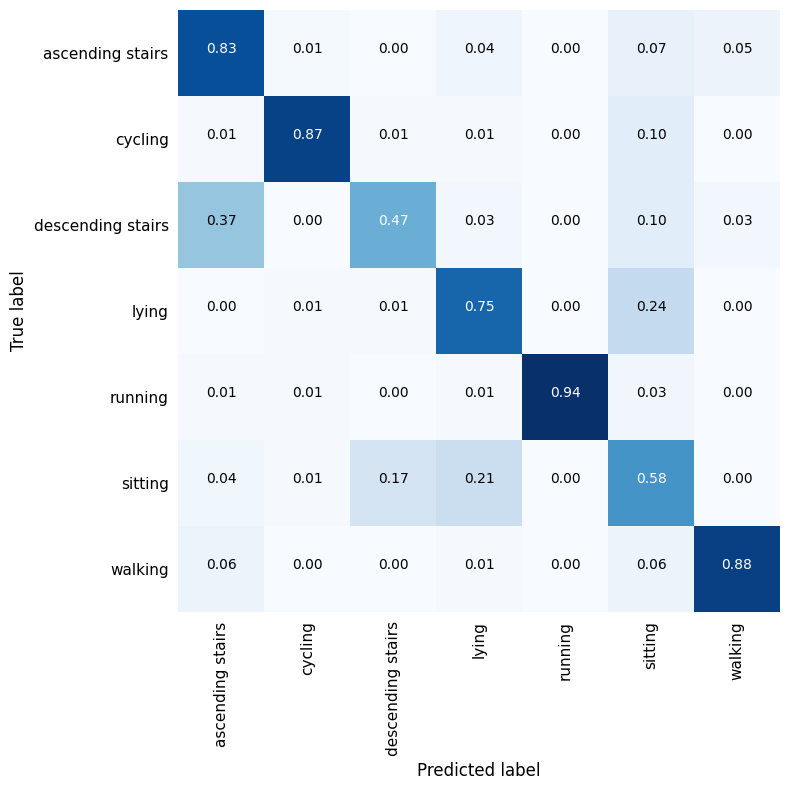

In [ ]:
pre_trained_model = tf.keras.models.load_model(f"{project_path}/Lab6/pre_trained_model")

enc = OneHotEncoder()
ohe_labels_test_for_pre_train = enc.fit_transform(labels[test_for_pre_train].reshape(-1,1)).toarray()

print("\nPredicting...")
y_preds = pre_trained_model.predict(samples[test_for_pre_train])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels_test_for_pre_train, axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes_pre_train, labels=np.array([i for i in range(len(classes_pre_train))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes_pre_train[el])
for el in y_targets: s_targets.append(classes_pre_train[el])

cm = [np.zeros([len(classes_pre_train)]) for _ in range(len(classes_pre_train))]
cm += confusion_matrix(s_targets, s_preds, labels=classes_pre_train)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes_pre_train)

<br>

It's time for fine-tuning

In [ ]:
def fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True, num_classes=len(classes)):
  feature_extractor = pre_trained_model.get_layer("conv3").output

  x = GlobalMaxPool1D(name='global_max_pooling')(feature_extractor)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x)

  model = Model(inputs=pre_trained_model.input, outputs=classification_out, name="fine_tuning_classifier")

  if freeze_feature_extractors:
    for layer in model.layers[:-2]: layer.trainable = False
  else:
    for layer in model.layers[:-2]: layer.trainable = True

  return model

<br>

Note how the number of trainable params changes based on the freezing/unfreezing option!

In [ ]:
pre_trained_model = tf.keras.models.load_model(f"{project_path}/Lab6/pre_trained_model")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True)
print(model.summary())

print("\nTrainable layers:")
for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "fine_tuning_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling (Global  (None, 96)     

In [ ]:
pre_trained_model = tf.keras.models.load_model(f"{project_path}/Lab6/pre_trained_model")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=False)
print(model.summary())

print("\nTrainable layers:")
for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "fine_tuning_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 6)]          0         
                                                                 
 conv1 (Conv1D)              (None, 177, 32)           4640      
                                                                 
 max_pool1 (MaxPooling1D)    (None, 174, 32)           0         
                                                                 
 conv2 (Conv1D)              (None, 159, 64)           32832     
                                                                 
 max_pool2 (MaxPooling1D)    (None, 156, 64)           0         
                                                                 
 conv3 (Conv1D)              (None, 149, 96)           49248     
                                                                 
 global_max_pooling (Global  (None, 96)     

<br>

Fine-tuning while freezing the feature extraction layers

Loading the pre-trained model...

Creating the new model to fine-tune...

Fine-tuning...
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 4.4808 - accuracy: 0.0270 - val_loss: 4.4418 - val_accuracy: 0.0000e+00
Epoch 2/1000
1/1 [==============================] - 0s 37ms/step - loss: 4.1764 - accuracy: 0.0270 - val_loss: 3.9230 - val_accuracy: 0.2000
Epoch 3/1000
1/1 [==============================] - 0s 47ms/step - loss: 3.9107 - accuracy: 0.0541 - val_loss: 3.5272 - val_accuracy: 0.2000
Epoch 4/1000
1/1 [==============================] - 0s 37ms/step - loss: 3.6997 - accuracy: 0.1351 - val_loss: 3.2451 - val_accuracy: 0.4000
Epoch 5/1000
1/1 [==============================] - 0s 35ms/step - loss: 3.5412 - accuracy: 0.1622 - val_loss: 3.0347 - val_accuracy: 0.4000
Epoch 6/1000
1/1 [==============================] - 0s 37ms/step - loss: 3.4161 - accuracy: 0.1892 - val_loss: 2.8600 - val_accuracy: 0.4000
Epoch 7/1000
1/1 [==============================] - 0s 38ms/ste

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

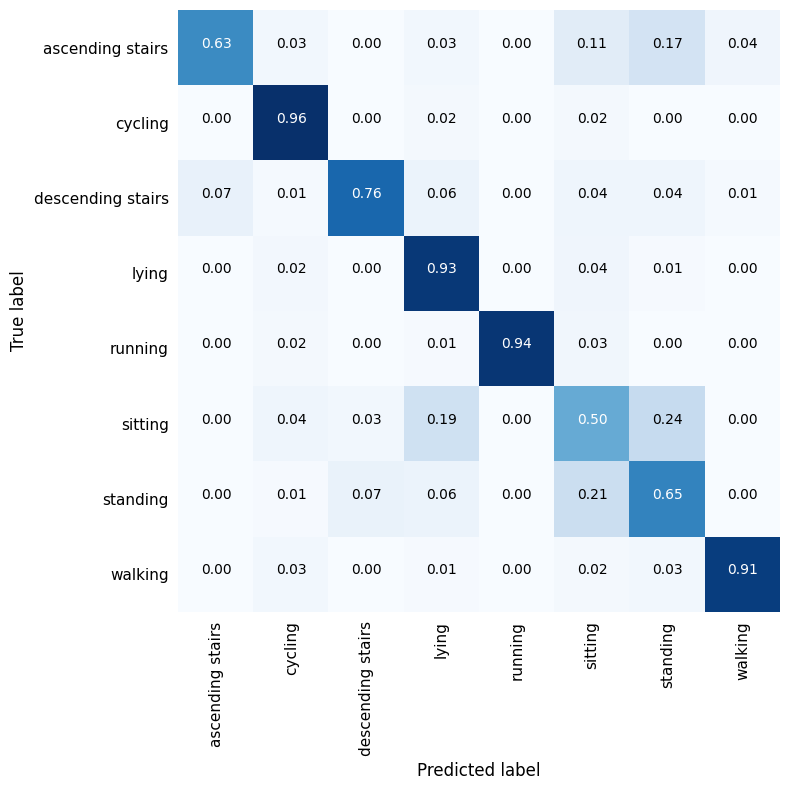

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 1000
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("Loading the pre-trained model...")
pre_trained_model = tf.keras.models.load_model(f"{project_path}/Lab6/pre_trained_model")


print("\nCreating the new model to fine-tune...")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

<br>

Fine-tuning without freezing the feature extraction layers

Loading the pre-trained model...

Creating the new model to fine-tune...

Fine-tuning...
Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 5.5800 - accuracy: 0.1351 - val_loss: 5.7415 - val_accuracy: 0.2000
Epoch 2/1000
1/1 [==============================] - 0s 71ms/step - loss: 5.0753 - accuracy: 0.1351 - val_loss: 5.0461 - val_accuracy: 0.2000
Epoch 3/1000
1/1 [==============================] - 0s 62ms/step - loss: 4.5864 - accuracy: 0.1351 - val_loss: 4.3602 - val_accuracy: 0.2000
Epoch 4/1000
1/1 [==============================] - 0s 65ms/step - loss: 4.1129 - accuracy: 0.1622 - val_loss: 3.6845 - val_accuracy: 0.2000
Epoch 5/1000
1/1 [==============================] - 0s 64ms/step - loss: 3.6564 - accuracy: 0.1892 - val_loss: 3.0227 - val_accuracy: 0.2000
Epoch 6/1000
1/1 [==============================] - 0s 64ms/step - loss: 3.2192 - accuracy: 0.1892 - val_loss: 2.4145 - val_accuracy: 0.2000
Epoch 7/1000
1/1 [==============================] - 0s 50ms/step - 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

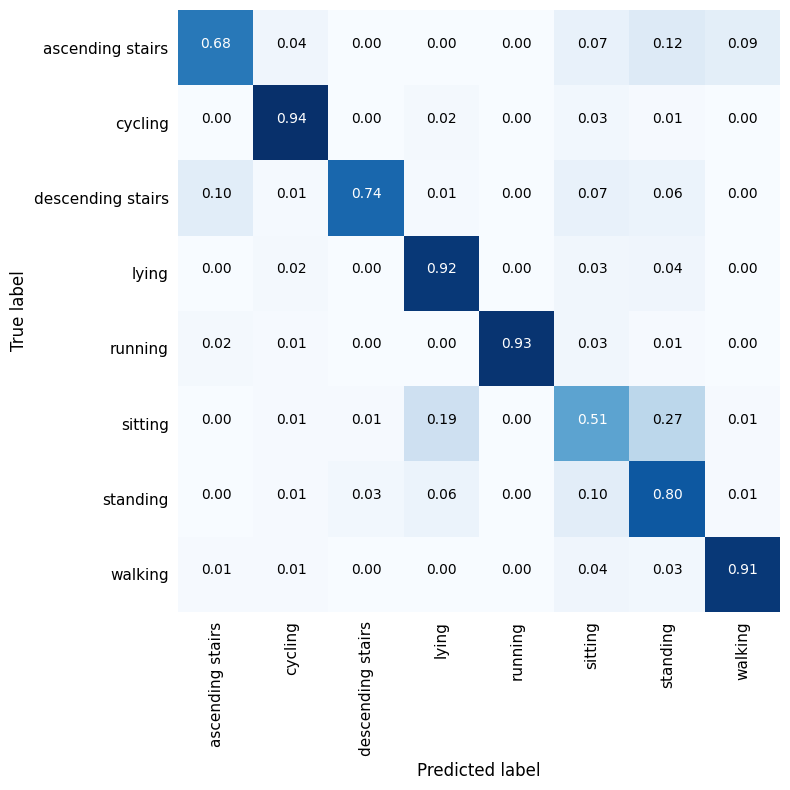

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 1000
batch_size = 128


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("Loading the pre-trained model...")
pre_trained_model = tf.keras.models.load_model(f"{project_path}/Lab6/pre_trained_model")


print("\nCreating the new model to fine-tune...")
model = fine_tune_classifier(pre_trained_model, freeze_feature_extractors=False)
model.compile(optimizer=keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

## Exercises

1. Try to change the activities that the pre-train model is able to classify. For instance, try to remove from the pre-train set an activity (e.g., Running) that the baseline is already able to classify with relatively high recognition rates on the fine-tuning set. What happens?

2. Try different percentages to reduce the available data for fine-tuning. When transfer learning is not effective anymore?

In [ ]:
# Your turn!

# Self-Supervised Learning

In [ ]:
f = open(f"{project_path}/Lab1/pamap2_2_seconds_0_overlap.txt", "rb")
pamap2 = pickle.load(f)

samples = pamap2["accelerometer_samples"]
labels, users = pamap2["labels"], pamap2["subjects"]

del pamap2

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

Samples: (9628, 200, 3)
Labels: (9628,)
Users: (9628,)


In [ ]:
activities_map = {
     0: "other",
     1: "lying",
     2: "sitting",
     3: "standing",
     4: "walking",
     5: "running",
     6: "cycling",
     7: "Nordic walking",
     9: "watching TV",
    10: "computer work",
    11: "car driving",
    12: "ascending stairs",
    13: "descending stairs",
    16: "vacuum cleaning",
    17: "ironing",
    18: "folding laundry",
    19: "house cleaning",
    20: "playing soccer",
    24: "rope jumping"
}

print(labels[0])
labels = np.array([activities_map[lab] for lab in list(labels)])
print(labels[0])

1
lying


In [ ]:
to_keep = np.where((labels != "rope jumping") & (labels != "Nordic walking") & (labels != "vacuum cleaning") & (labels != "ironing"))[0]

samples, labels, users = samples[to_keep], labels[to_keep], users[to_keep]

print("Samples:", samples.shape)
print("Labels:", labels.shape)
print("Users:", users.shape)

classes = sorted(list(set(labels)))
print("Classes:", classes)

Samples: (6397, 200, 3)
Labels: (6397,)
Users: (6397,)
Classes: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']


In [ ]:
enc = OneHotEncoder()
ohe_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

print(f"Original list of labels: {classes}")

print(f'Example of original label: {labels[3000]}')
print(f"...and the corresponding one-hot encoded version: {ohe_labels[3000]}")

Original list of labels: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']
Example of original label: cycling
...and the corresponding one-hot encoded version: [0. 1. 0. 0. 0. 0. 0. 0.]


<br>

Similar scenario we've seen for Transfer Learning.

We split the dataset into:

* **Pre-train set**: unlabeled data from different subjects

* **Fine-tuning set**: low amount of labeled data from the new subject,

* **Test set**: labeled data from the new subject, useful to validate our transfer learning solution


Then, we will compare three approaches:
* **Baseline**: a model trained only on the available labeled data (i.e., the fine-tuning set)

* **AutoEncoder-based Self-supervised method**: a model pre-trained on the unlabeled data (i.e., the pre-train set) thanks to an AutoEncoder, and then fine-tuned on the small fine-tuning set.

* **Sim-CLR-based Self-supervised method**: a model pre-trained on the unlabeled data (i.e., the pre-train set) thanks to the Sim-CLR framework, and then fine-tuned on the small fine-tuning set.

In [ ]:
pre_train = np.where((users != 101))[0]
fine_tuning = np.where((users == 101))[0]

# from the data of the new subject, we use 30% for fine-tuning and 70% for test
fine_tuning, test, _, _ = train_test_split(fine_tuning, labels[fine_tuning], test_size=0.70, random_state=0)

print(f"Pre-train size: {len(pre_train)} ({len(pre_train)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(pre_train)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[pre_train])))}")
print(f"Fine-tuning size: {len(fine_tuning)} ({len(fine_tuning)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%) -> {len(fine_tuning)*2/60:.2f} minutes of data. Activities: {sorted(list(set(labels[fine_tuning])))}")
print(f"Test size: {len(test)} ({len(test)/(len(pre_train)+len(fine_tuning)+len(test))*100:.2f}%). Activities: {sorted(list(set(labels[test])))}")

Pre-train size: 5553 (86.81%) -> 185.10 minutes of data. Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']
Fine-tuning size: 253 (3.95%) -> 8.43 minutes of data. Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']
Test size: 591 (9.24%). Activities: ['ascending stairs', 'cycling', 'descending stairs', 'lying', 'running', 'sitting', 'standing', 'walking']


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, cmap=plt.cm.Blues, figsize=(22,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=+++90, fontsize=11)
    plt.yticks(tick_marks, classes, fontsize=11)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black"
               )

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.tick_params(axis="both", which="both", bottom=False, left=False)
    plt.grid(False)
    plt.box(False) #remove box
    return plt

## Baseline

In [ ]:
def baseline(num_classes=len(classes)):
  input = Input((200, 3), name="input")
  x1 = Conv1D(filters=32, kernel_size=24, activation='relu', name="conv1")(input)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool1")(x1)
  x1 = Conv1D(filters=64, kernel_size=16, activation='relu', name="conv2")(x1)
  x1 = MaxPooling1D(4, 1, padding="valid", name="max_pool2")(x1)
  x1 = Conv1D(filters=96, kernel_size=8, activation='relu', name="conv3")(x1)
  x1 = GlobalMaxPool1D(name='global_max_pooling1d')(x1)
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(x1)

  model = Model(inputs=input, outputs=classification_out, name="baseline")

  return model

Normalizing data...

Creating the model...

Training...
Epoch 1/200
8/8 [==============================] - 3s 112ms/step - loss: 2.0653 - accuracy: 0.1542 - val_loss: 2.0371 - val_accuracy: 0.1154
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 2.0119 - accuracy: 0.1938 - val_loss: 1.9703 - val_accuracy: 0.1923
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 1.9603 - accuracy: 0.3040 - val_loss: 1.9064 - val_accuracy: 0.1923
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 1.8735 - accuracy: 0.3040 - val_loss: 1.8553 - val_accuracy: 0.1923
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 1.7179 - accuracy: 0.3480 - val_loss: 1.7460 - val_accuracy: 0.2308
Epoch 6/200
8/8 [==============================] - 0s 9ms/step - loss: 1.5784 - accuracy: 0.4097 - val_loss: 1.5627 - val_accuracy: 0.2692
Epoch 7/200
8/8 [==============================] - 0s 8ms/step - loss: 1.5189 - accuracy: 0.4053 - val_loss:

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

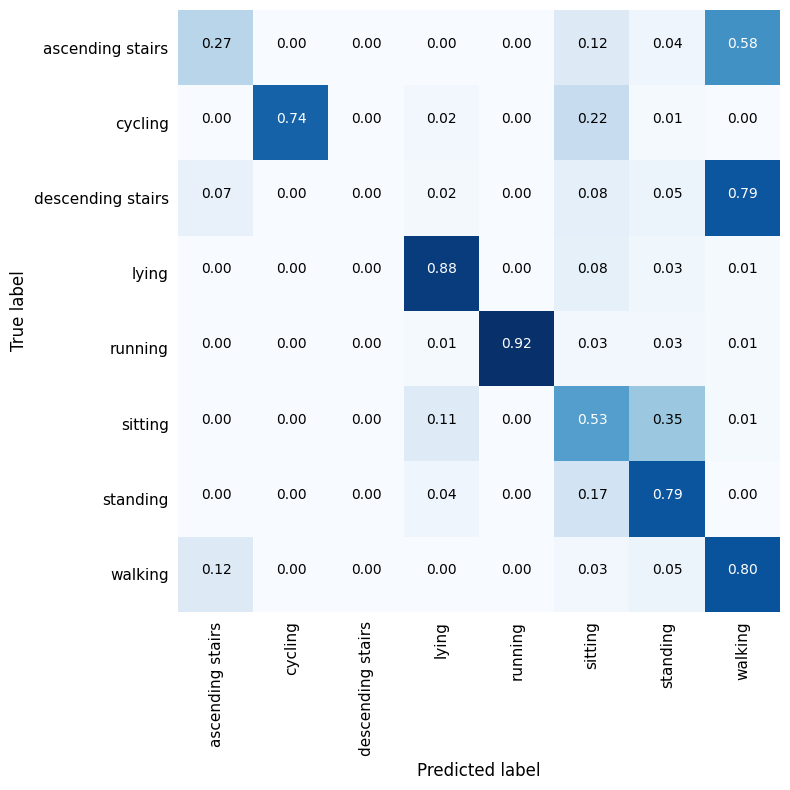

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 200
batch_size = 32


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


# When we'll create the AutoEncoder, we'll see why here we need to normalize
print("Normalizing data...")
samples_fine_tuning = (samples_fine_tuning - np.min(samples_fine_tuning)) / (np.max(samples_fine_tuning) - np.min(samples_fine_tuning))
samples_val = (samples_val - np.min(samples_val)) / (np.max(samples_val) - np.min(samples_val))
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))


print("\nCreating the model...")
model = baseline()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


print("\nTraining...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

## Auto-Encoder

In [ ]:
def autoencoder():
  # Encoder
  input = Input((200, 3), name="input")
  x = Flatten(name="enc_flatten")(input)
  x = Dense(256, activation="relu", name="enc_dense1")(x)

  # Latent representation learned by the Encoder
  encoded = Dense(128, activation="relu", name="latent_representation_layer")(x)

  # Decoder
  x = Dense(256, activation="relu", name="dec_dense1")(encoded)
  x = Dense(200*3, activation="sigmoid", name="dec_dense2")(x)
  decoded = Reshape((200,3), name="dec_reshape")(x)

  autoencoder = Model(input, decoded, name="autoencoder")

  encoder = Model(input, encoded, name="encoder")

  return autoencoder, encoder

In [ ]:
autoencoder_model, encoder_model = autoencoder()
print(autoencoder_model.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 enc_flatten (Flatten)       (None, 600)               0         
                                                                 
 enc_dense1 (Dense)          (None, 256)               153856    
                                                                 
 latent_representation_laye  (None, 128)               32896     
 r (Dense)                                                       
                                                                 
 dec_dense1 (Dense)          (None, 256)               33024     
                                                                 
 dec_dense2 (Dense)          (None, 600)               154200    
                                                       

In [ ]:
print(encoder_model.summary())

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 enc_flatten (Flatten)       (None, 600)               0         
                                                                 
 enc_dense1 (Dense)          (None, 256)               153856    
                                                                 
 latent_representation_laye  (None, 128)               32896     
 r (Dense)                                                       
                                                                 
Total params: 186752 (729.50 KB)
Trainable params: 186752 (729.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


<br>

Let's train our Autoencoder.

There is a very important aspect to consider. Our decoder uses the sigmoid activation function in the last layer. This creates an output of values in the range [0,1]. During training, our loss will compare each input sample with the corresponding decoded sample. So, also the input samples should have values in the range [0,1]!

So, before training the Autoencoder, we will normalize the input data. We did the same for the baseline, to obtain a better comparison between the different approaches

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

n_epochs = 1000
batch_size = 32


# get validation data
samples_pre_train, samples_val, _, _ = train_test_split(samples[pre_train], ohe_labels[pre_train], test_size=0.1)


print("Normalizing data...")
samples_pre_train = (samples_pre_train - np.min(samples_pre_train)) / (np.max(samples_pre_train) - np.min(samples_pre_train))
samples_val = (samples_val - np.min(samples_val)) / (np.max(samples_val) - np.min(samples_val))


print("\nCreating the Autoencoder...")
autoencoder_model, encoder_model = autoencoder()
autoencoder_model.compile(loss='binary_crossentropy',
                          optimizer='adam')
                          #optimizer=keras.optimizers.Adam(0.00001))

print("\nTraining...")
history = autoencoder_model.fit(x=samples_pre_train,
                  y=samples_pre_train,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, samples_val),
                  callbacks=[early_stopping])

Normalizing data...

Creating the Autoencoder...

Training...
Epoch 1/1000
157/157 [==============================] - 2s 5ms/step - loss: 0.6850 - val_loss: 0.7027
Epoch 2/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6843 - val_loss: 0.7020
Epoch 3/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6841 - val_loss: 0.7039
Epoch 4/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6841 - val_loss: 0.7011
Epoch 5/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6840 - val_loss: 0.7004
Epoch 6/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.7014
Epoch 7/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.7017
Epoch 8/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6839 - val_loss: 0.6984
Epoch 9/1000
157/157 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.7013
Epoch 10/1000
157/15

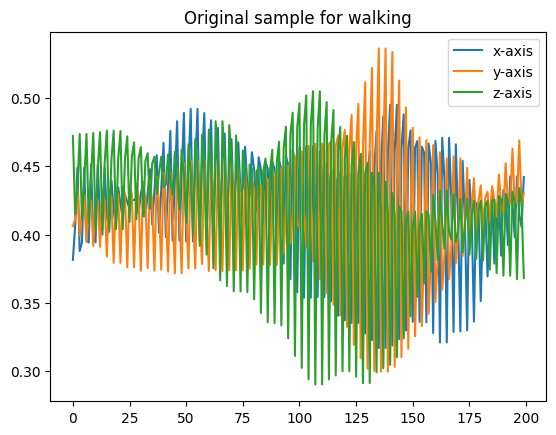

In [ ]:
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))

idx = 100

plt.plot(list(range(200)), samples_test[idx].reshape((3,200))[0], label="x-axis")
plt.plot(list(range(200)), samples_test[idx].reshape((3,200))[1], label="y-axis")
plt.plot(list(range(200)), samples_test[idx].reshape((3,200))[2], label="z-axis")
plt.title(f"Original sample for {labels[test][idx]}")
plt.legend()
plt.show()

1/1 [==============================] - 0s 81ms/step


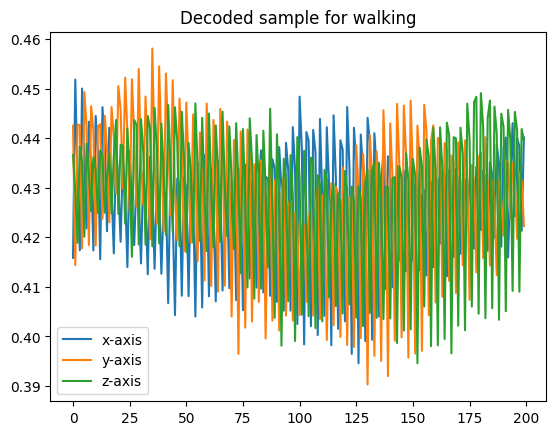

In [ ]:
decoded_sample = autoencoder_model.predict(samples_test[idx].reshape((1,200,3)))[0]

plt.plot(list(range(200)), decoded_sample.reshape((3,200))[0], label="x-axis")
plt.plot(list(range(200)), decoded_sample.reshape((3,200))[1], label="y-axis")
plt.plot(list(range(200)), decoded_sample.reshape((3,200))[2], label="z-axis")
plt.title(f"Decoded sample for {labels[test][idx]}")
plt.legend()
plt.show()

In [ ]:
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))

features = encoder_model.predict(samples_test)
print(features.shape)

19/19 [==============================] - 0s 2ms/step
(591, 128)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 591 samples in 0.001s...
[t-SNE] Computed neighbors for 591 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.104663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.149117
[t-SNE] KL divergence after 1000 iterations: 0.310745


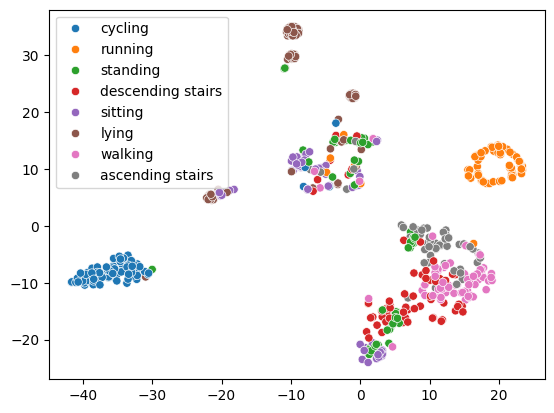

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

features_embedded = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(features)

sns.scatterplot(x=features_embedded[:,0], y=features_embedded[:,1], hue=[lab for lab in labels[test]])
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 591 samples in 0.003s...
[t-SNE] Computed neighbors for 591 samples in 0.043s...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.242590
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.628380
[t-SNE] KL divergence after 1000 iterations: 0.487172


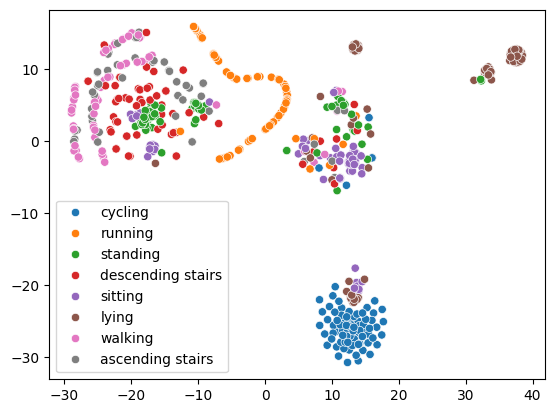

In [ ]:
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))

samples_reduced = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(samples_test.reshape((-1, 200*3)))

sns.scatterplot(x=samples_reduced[:,0], y=samples_reduced[:,1], hue=[lab for lab in labels[test]])
plt.show()

<br>

Now, we can use the Encoder of our Autoencoder which is able to extract features from raw accelerometer data and fine tune it!

In [ ]:
def autoencoder_based_classifier(encoder, freeze_feature_extractors=True, num_classes=len(classes)):
  feature_extractor = encoder.get_layer("latent_representation_layer").output
  classification_out = Dense(num_classes, activation='softmax', name="classification_out")(feature_extractor)

  model = Model(inputs=encoder.input, outputs=classification_out, name="autoencoder_based_classifier")

  if freeze_feature_extractors:
    for layer in model.layers[:-1]: layer.trainable = False
  else:
    for layer in model.layers[:-1]: layer.trainable = True

  return model

In [ ]:
model = autoencoder_based_classifier(encoder_model)
print(model.summary())

for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "autoencoder_based_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 enc_flatten (Flatten)       (None, 600)               0         
                                                                 
 enc_dense1 (Dense)          (None, 256)               153856    
                                                                 
 latent_representation_laye  (None, 128)               32896     
 r (Dense)                                                       
                                                                 
 classification_out (Dense)  (None, 8)                 1032      
                                                                 
Total params: 187784 (733.53 KB)
Trainable params: 1032 (4.03 KB)
Non-trainable params: 186752 (729.50 K

In [ ]:
model = autoencoder_based_classifier(encoder_model, freeze_feature_extractors=False)
print(model.summary())

for layer in model.layers:
  print(layer.name, layer.trainable)

Model: "autoencoder_based_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 enc_flatten (Flatten)       (None, 600)               0         
                                                                 
 enc_dense1 (Dense)          (None, 256)               153856    
                                                                 
 latent_representation_laye  (None, 128)               32896     
 r (Dense)                                                       
                                                                 
 classification_out (Dense)  (None, 8)                 1032      
                                                                 
Total params: 187784 (733.53 KB)
Trainable params: 187784 (733.53 KB)
Non-trainable params: 0 (0.00 Byte


Creating the new model to fine-tune...

Fine-tuning...
Epoch 1/2000
1/1 [==============================] - 1s 726ms/step - loss: 2.1443 - accuracy: 0.0441 - val_loss: 2.1092 - val_accuracy: 0.0769
Epoch 2/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.1375 - accuracy: 0.0529 - val_loss: 2.1032 - val_accuracy: 0.0769
Epoch 3/2000
1/1 [==============================] - 0s 31ms/step - loss: 2.1306 - accuracy: 0.0705 - val_loss: 2.0972 - val_accuracy: 0.1154
Epoch 4/2000
1/1 [==============================] - 0s 37ms/step - loss: 2.1238 - accuracy: 0.0749 - val_loss: 2.0912 - val_accuracy: 0.1154
Epoch 5/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.1171 - accuracy: 0.0705 - val_loss: 2.0852 - val_accuracy: 0.1154
Epoch 6/2000
1/1 [==============================] - 0s 34ms/step - loss: 2.1104 - accuracy: 0.0705 - val_loss: 2.0793 - val_accuracy: 0.1154
Epoch 7/2000
1/1 [==============================] - 0s 33ms/step - loss: 2.1037 - accuracy: 0.066

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

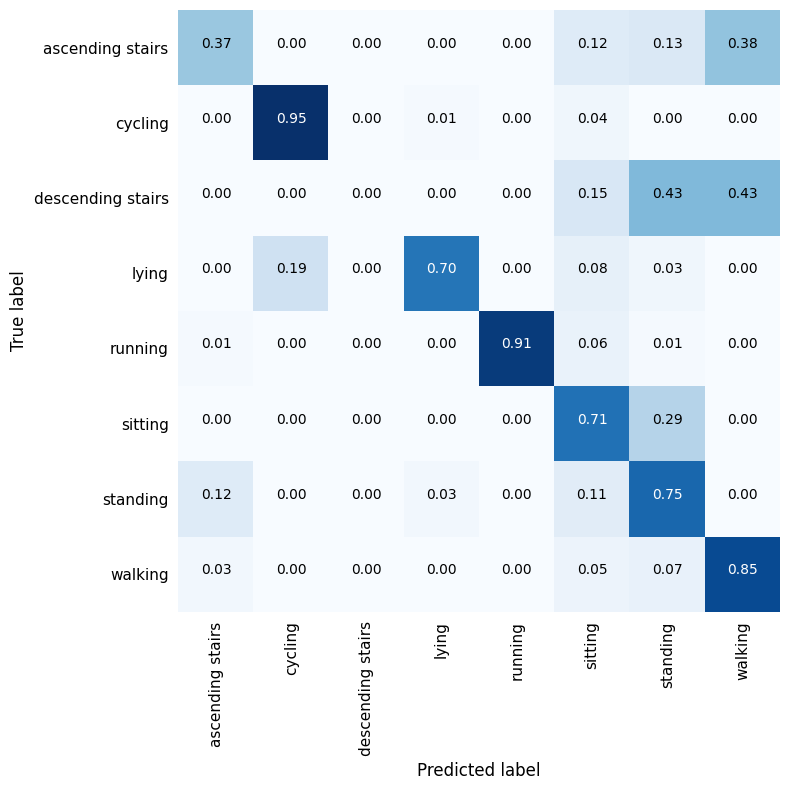

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 2000
batch_size = len(fine_tuning)


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


#print("Normalizing data...")
samples_fine_tuning = (samples_fine_tuning - np.min(samples_fine_tuning)) / (np.max(samples_fine_tuning) - np.min(samples_fine_tuning))
samples_val = (samples_val - np.min(samples_val)) / (np.max(samples_val) - np.min(samples_val))
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))


print("\nCreating the new model to fine-tune...")
model = autoencoder_based_classifier(encoder_model, freeze_feature_extractors=True)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

Normalizing data...

Creating the new model to fine-tune...

Fine-tuning...
Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 2.0939 - accuracy: 0.0220 - val_loss: 2.0423 - val_accuracy: 0.1154
Epoch 2/2000
1/1 [==============================] - 0s 37ms/step - loss: 2.0384 - accuracy: 0.2070 - val_loss: 1.9869 - val_accuracy: 0.2692
Epoch 3/2000
1/1 [==============================] - 0s 39ms/step - loss: 1.9940 - accuracy: 0.3348 - val_loss: 1.9452 - val_accuracy: 0.2692
Epoch 4/2000
1/1 [==============================] - 0s 44ms/step - loss: 1.9484 - accuracy: 0.3524 - val_loss: 1.9045 - val_accuracy: 0.2692
Epoch 5/2000
1/1 [==============================] - 0s 53ms/step - loss: 1.9036 - accuracy: 0.3524 - val_loss: 1.8758 - val_accuracy: 0.2692
Epoch 6/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.8677 - accuracy: 0.3524 - val_loss: 1.8569 - val_accuracy: 0.3077
Epoch 7/2000
1/1 [==============================] - 0s 35ms/step - loss: 1.8340 

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

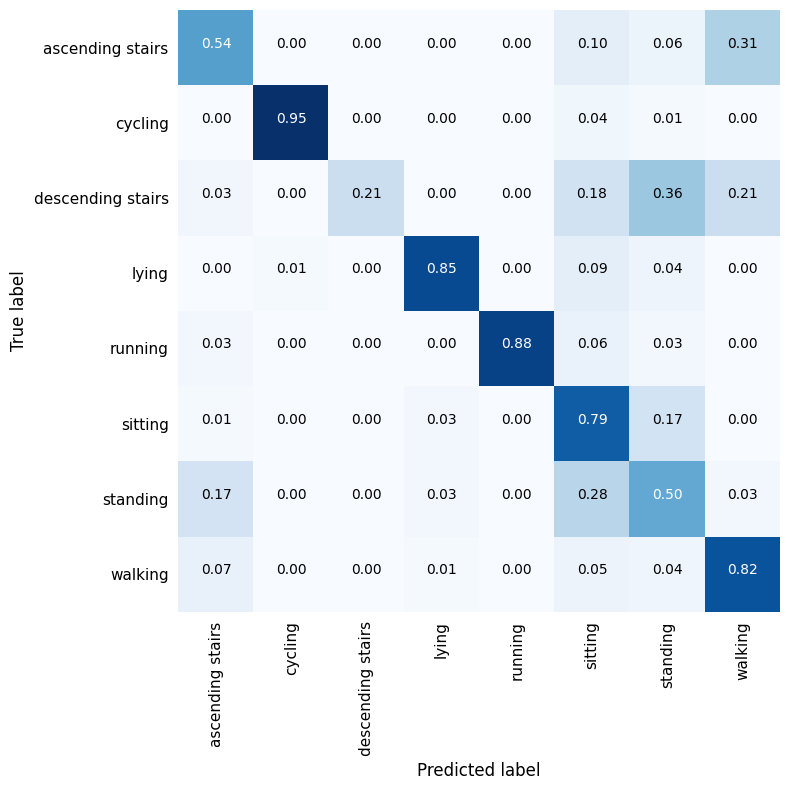

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 2000
batch_size = len(fine_tuning)


# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("Normalizing data...")
samples_fine_tuning = (samples_fine_tuning - np.min(samples_fine_tuning)) / (np.max(samples_fine_tuning) - np.min(samples_fine_tuning))
samples_val = (samples_val - np.min(samples_val)) / (np.max(samples_val) - np.min(samples_val))
samples_test = samples[test]
samples_test = (samples_test - np.min(samples_test)) / (np.max(samples_test) - np.min(samples_test))


print("\nCreating the new model to fine-tune...")
model = autoencoder_based_classifier(encoder_model, freeze_feature_extractors=False)
#model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0001), metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])


print("\nFine-tuning...")
history = model.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = model.predict(samples_test)

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)

## Sim-CLR

In [ ]:
def axis_angle_to_rotation_matrix_3d(axes, angles):
    """
    Get the rotational matrix corresponding to a rotation of (angle) radian around the axes
    Reference: the Transforms3d package - transforms3d.axangles.axangle2mat
    Formula: http://en.wikipedia.org/wiki/Rotation_matrix#Axis_and_angle
    """
    axes = axes / np.linalg.norm(axes, ord=2, axis=1, keepdims=True)
    x = axes[:, 0]; y = axes[:, 1]; z = axes[:, 2]
    c = np.cos(angles)
    s = np.sin(angles)
    C = 1 - c

    xs = x*s;   ys = y*s;   zs = z*s
    xC = x*C;   yC = y*C;   zC = z*C
    xyC = x*yC; yzC = y*zC; zxC = z*xC

    m = np.array([
        [ x*xC+c,   xyC-zs,   zxC+ys ],
        [ xyC+zs,   y*yC+c,   yzC-xs ],
        [ zxC-ys,   yzC+xs,   z*zC+c ]])
    matrix_transposed = np.transpose(m, axes=(2,0,1))
    return matrix_transposed


def rotation_transform(X):
    """
    Applying a random 3D rotation
    """
    axes = np.random.uniform(low=-1, high=1, size=(X.shape[0], X.shape[2]))
    angles = np.random.uniform(low=-np.pi, high=np.pi, size=(X.shape[0]))
    matrices = axis_angle_to_rotation_matrix_3d(axes, angles)

    return np.matmul(X, matrices)


def noise_transform(X, sigma=0.05):
    """
    Adding random Gaussian noise with mean 0
    """
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise


def scaling_transform(X, sigma=0.1):
    """
    Scaling by a random factor
    """
    scaling_factor = np.random.normal(loc=1.0, scale=sigma, size=(X.shape[0], 1, X.shape[2]))
    return X * scaling_factor


def time_flip_transform(X):
    """
    Reversing the direction of time
    """
    return X[:, ::-1, :]


def negate_transform(X):
    """
    Inverting the signals
    """
    return X * -1

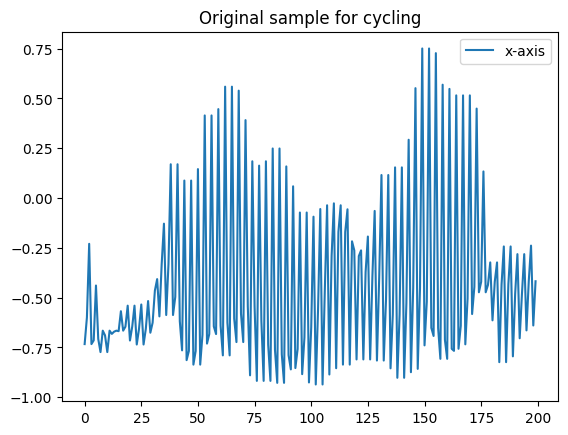

In [ ]:
idx = 3000
sample_to_plot = samples[idx].reshape((3,200))

plt.plot(list(range(200)), sample_to_plot[0], label="x-axis")
plt.title(f"Original sample for {labels[idx]}")
plt.legend()
plt.show()

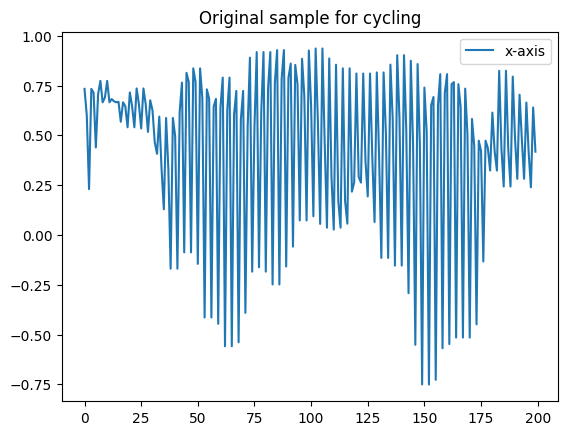

In [ ]:
idx = 3000
sample_to_plot = negate_transform(samples[idx].reshape((1,200,3)))
sample_to_plot = sample_to_plot.reshape((3,200))

plt.plot(list(range(200)), sample_to_plot[0], label="x-axis")
plt.title(f"Original sample for {labels[idx]}")
plt.legend()
plt.show()

<br>

Let's define the Sim-CLR model

In [ ]:
def create_base_model(input_shape=(200,3)):
    inputs = tf.keras.Input(shape=input_shape, name='input')

    x = Conv1D(32, 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(inputs)
    x = Dropout(0.1)(x)

    x = Conv1D(64, 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(x)
    x = Dropout(0.1)(x)

    x = Conv1D(96, 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=1e-4))(x)
    x = Dropout(0.1)(x)

    x = GlobalMaxPool1D(data_format='channels_last', name='global_max_pooling1d')(x)

    return Model(inputs, x, name="base_model")

In [ ]:
def attach_simclr_head(base_model):
    input = base_model.input
    x = base_model.output

    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    return Model(input, x, name="sim_clr_model")

In [ ]:
base_model = create_base_model()
simclr_model = attach_simclr_head(base_model)
print(simclr_model.summary())

Model: "sim_clr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 177, 32)           2336      
                                                                 
 dropout (Dropout)           (None, 177, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 162, 64)           32832     
                                                                 
 dropout_1 (Dropout)         (None, 162, 64)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 155, 96)           49248     
                                                                 
 dropout_2 (Dropout)         (None, 155, 96)         

<br>

This is an adaptation of the train function implemented in the original paper

In [ ]:
import math
import random

def simclr_train_model(model, training_set, optimizer, batch_size, transformation_function, temperature=1.0, epochs=100, verbose=0):
    epoch_wise_loss = []

    for epoch in range(epochs):
        step_wise_loss = []

        # Randomly shuffle the dataset
        indices = np.arange(len(training_set))
        np.random.shuffle(indices)
        shuffled_dataset = training_set[indices]

        # Training
        num_batches = math.ceil(len(training_set) / batch_size)

        for i in range(num_batches):
            data_batch = shuffled_dataset[i * batch_size : (i + 1) * batch_size]

            # Apply transformation
            transform_1 = transformation_function(data_batch)
            transform_2 = transformation_function(data_batch)

            # Forward propagation
            loss, gradients = get_NT_Xent_loss_gradients(model, transform_1, transform_2, normalize=True, temperature=temperature, weights=1.0)

            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))

        if verbose > 0:
            print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return model, epoch_wise_loss





def get_NT_Xent_loss_gradients(model, samples_transform_1, samples_transform_2, normalize=True, temperature=1.0, weights=1.0):
    with tf.GradientTape() as tape:
        hidden_features_transform_1 = model(samples_transform_1)
        hidden_features_transform_2 = model(samples_transform_2)
        loss = NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=normalize, temperature=temperature, weights=weights)

    gradients = tape.gradient(loss, model.trainable_variables)
    return loss, gradients




# this Python decorator allows increasing the performance
@tf.function
def NT_Xent_loss(hidden_features_transform_1, hidden_features_transform_2, normalize=True, temperature=1.0, weights=1.0):
    """
    The normalised temperature-scaled cross entropy loss function of SimCLR Contrastive training
    Reference: Chen, T., Kornblith, S., Norouzi, M., & Hinton, G. (2020). A simple framework for contrastive learning of visual representations. arXiv preprint arXiv:2002.05709.
    https://github.com/google-research/simclr/blob/master/objective.py
    Parameters:
        hidden_features_transform_1: the features (activations) extracted from the inputs after applying transformation 1 (e.g. model(transform_1(X)))
        hidden_features_transform_2: the features (activations) extracted from the inputs after applying transformation 2 (e.g. model(transform_2(X)))
        normalize = True: normalise the activations if true
        temperature: hyperparameter, the scaling factor of the logits. The authors found that an appropriate temperature parameter can help the model learn from negatives samples
        weights: weights of different samples
    """
    LARGE_NUM = 1e9

    h1 = hidden_features_transform_1
    h2 = hidden_features_transform_2
    if normalize:
        h1 = tf.math.l2_normalize(h1, axis=1)
        h2 = tf.math.l2_normalize(h2, axis=1)

    batch_size = tf.shape(hidden_features_transform_1)[0]
    masks = tf.one_hot(tf.range(batch_size), batch_size)   # this is an identity matrix of size batch_size [[1, 0, 0, ...], [0, 1, 0, ...], [0, 0, 1, ...]]

    # here we get the cosine distance (i.e., similarity) between samples transformed with the first transformation
    # in the result, the value at [i][j] is the cosine distance between i-th and j-th embeddings in the input matrix
    # note that above we normalized the hidden features, so the cosine similarity can be obtained through the dot product, without any further normalization of the vectors
    # logits_h1h1 will be something like
    # [[sim(X_h1, X_h1), sim(X_h1, Y_h1), sim(X_h1, Z_h1), ...],
    #  [sim(Y_h1, X_h1), sim(Y_h1, Y_h1), sim(Y_h1, Z_h1), ...],
    #  ...]
    # where X, Y, Z, ... are unlabeled samples from the training set, and
    # X_h1 is, for instance, the embeddings obtained by the model on the sample X transformed with the first transformation
    logits_h1h1 = tf.matmul(h1, h1, transpose_b=True) / temperature
    logits_h1h1 = logits_h1h1 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between samples transformed with the second transformation
    logits_h2h2 = tf.matmul(h2, h2, transpose_b=True) / temperature
    logits_h2h2 = logits_h2h2 - masks * LARGE_NUM   # suppress the similarity between each transformed sample with itself, because we don't want to maximize this similarity. Here, we give a very low value to this similarity, so that it is already "minimized" during the training process

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the first transformation and transformed with the second transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    # logits_h1h2 will be something like
    # [[sim(X_h1, X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...],
    #  [sim(Y_h1, X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #  ...]
    logits_h1h2 = tf.matmul(h1, h2, transpose_b=True) / temperature

    # here we get the cosine distance (i.e., similarity) between the samples transformed with the second transformation and transformed with the first transformation
    # note that, we will maximize the similarities on the diagonal of this matrix!
    logits_h2h1 = tf.matmul(h2, h1, transpose_b=True) / temperature

    # from_logits=True can be used when the output of the machine learning model is not a probabiity distribution
    # Sparse because the labels will be provided as integers and not in a one-hot-encoded format
    entropy_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    labels = tf.range(batch_size)   # labels will be [0, 1, ..., batch_size-1], hence, they are provided as integers

    # Typically, SparseCrossEntropy works like this:
    # labels = [0, 1, 0, ...]
    # classifier_predictions = [[0.95, 0.05, 0], [0, 0.80, 0.20], [0.99, 0, 0.01], ...]
    # example: in the first prediction, the label is 0, hence, the model will try to maximize
    #          the probability value of the probability distribution that is at index 0

    # In this implementation, the maximum similarity must correspond to value at the index encoded by the label
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h1,X_h2), sim(X_h1, Y_h2), sim(X_h1, Z_h2), ...<other elements of logits_h1h2>..., sim(X_h1, X_h1), sim(X_h1, Y_h1), ...<other elements of logits_h1h1>...],
    #                [sim(Y_h1,X_h2), sim(Y_h1, Y_h2), sim(Y_h1, Z_h2), ...],
    #                ...
    # Hence, for the first row, the model will try to maximize the similarity at index 0, that is sim(X_h1, X_h2) and to minimize all the other similarities in the row
    # For the second row, the model will try to maximize the similarity ad index 1, that is sim(Y_h1, Y_h2) and to minimize all the other similarities in the row
    loss_a = entropy_function(labels, tf.concat([logits_h1h2, logits_h1h1], 1), sample_weight=weights)

    # We can also consider the inverted case
    # labels = [0, 1, 2, ...]
    # similarities = [sim(X_h2,X_h1), sim(X_h2, Y_h1), sim(X_h2, Z_h1), ...<other elements of logits_h2h1>..., sim(X_h2, X_h2), sim(X_h2, Y_h2), ...<other elements of logits_h2h2>...],
    #                [sim(Y_h2,X_h1), sim(Y_h2, Y_h1), sim(Y_h2, Z_h1), ...],
    #                ...
    loss_b = entropy_function(labels, tf.concat([logits_h2h1, logits_h2h2], 1), sample_weight=weights)

    # the final loss will be the simple sum of the two previous ones
    loss = loss_a + loss_b

    return loss

In [ ]:
batch_size = 512
epochs = 200

decay_steps = 1000   # hyperparameter of the loss function used in the original paper
temperature = 0.1    # a scaling function used by Sim-CLR during contrastive learning

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

trained_simclr_model, epoch_losses = simclr_train_model(simclr_model,
                                                        samples[pre_train],
                                                        optimizer,
                                                        batch_size,
                                                        rotation_transform,
                                                        temperature=temperature,
                                                        epochs=epochs,
                                                        verbose=1)

trained_simclr_model.save(f"{project_path}/Lab6/simclr_model")

epoch: 1 loss: 13.270
epoch: 2 loss: 13.172
epoch: 3 loss: 12.463
epoch: 4 loss: 11.532
epoch: 5 loss: 11.656
epoch: 6 loss: 11.396
epoch: 7 loss: 10.877
epoch: 8 loss: 10.721
epoch: 9 loss: 11.000
epoch: 10 loss: 10.659
epoch: 11 loss: 10.165
epoch: 12 loss: 10.243
epoch: 13 loss: 9.909
epoch: 14 loss: 10.691
epoch: 15 loss: 10.088
epoch: 16 loss: 9.886
epoch: 17 loss: 9.865
epoch: 18 loss: 9.556
epoch: 19 loss: 9.760
epoch: 20 loss: 9.686
epoch: 21 loss: 9.460
epoch: 22 loss: 9.156
epoch: 23 loss: 9.452
epoch: 24 loss: 9.230
epoch: 25 loss: 8.980
epoch: 26 loss: 8.968
epoch: 27 loss: 8.939
epoch: 28 loss: 8.991
epoch: 29 loss: 8.723
epoch: 30 loss: 8.777
epoch: 31 loss: 8.369
epoch: 32 loss: 8.604
epoch: 33 loss: 8.394
epoch: 34 loss: 8.454
epoch: 35 loss: 8.053
epoch: 36 loss: 8.087
epoch: 37 loss: 7.982
epoch: 38 loss: 7.975
epoch: 39 loss: 7.967
epoch: 40 loss: 7.775
epoch: 41 loss: 7.578
epoch: 42 loss: 7.530
epoch: 43 loss: 7.401
epoch: 44 loss: 7.284
epoch: 45 loss: 7.284
epoch

epoch: 200 loss: 4.377


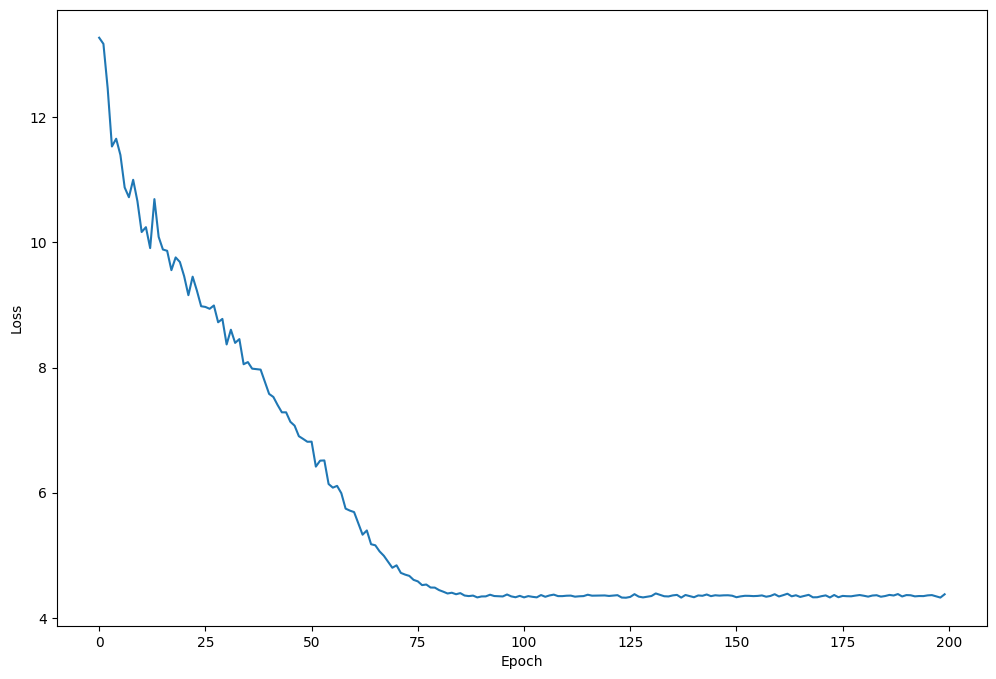

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

<br>

Let's see the embeddings in the latent space

19/19 [==============================] - 0s 9ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 591 samples in 0.001s...
[t-SNE] Computed neighbors for 591 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 591 / 591
[t-SNE] Mean sigma: 0.627061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.756561
[t-SNE] KL divergence after 1000 iterations: 0.265325


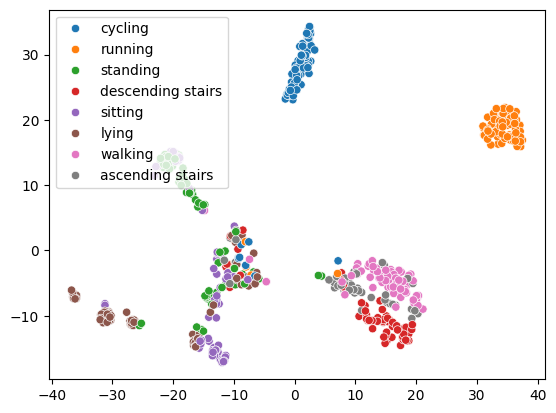

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

intermediate_model = Model(inputs=base_model.inputs, outputs=base_model.get_layer("global_max_pooling1d").output)

embeddings = intermediate_model.predict(samples[test])

features_reduced = TSNE(perplexity=30, verbose=1, random_state=42).fit_transform(embeddings)

sns.scatterplot(x=features_reduced[:,0], y=features_reduced[:,1], hue=[lab for lab in labels[test]])
plt.show()

<br>

After pre-training, we can fine-tune the Sim-CLR model with our fine-tuning set

In [ ]:
def create_full_classification_model_from_base_model(base_model, num_classes=len(classes), last_freeze_layer=4):
    intermediate_x = base_model.get_layer("global_max_pooling1d").output

    x = Dense(1024, activation='relu')(intermediate_x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.inputs, outputs=outputs, name="sim_clr_based_classifier")

    for layer in model.layers:
        layer.trainable = False

    for layer in model.layers[last_freeze_layer+1:]:
        layer.trainable = True

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

Creating the model...



Training...
Epoch 1/50
2/2 [==============================] - 3s 680ms/step - loss: 3.5840 - accuracy: 0.1586 - val_loss: 1.8103 - val_accuracy: 0.1538
Epoch 2/50
2/2 [==============================] - 0s 48ms/step - loss: 1.7431 - accuracy: 0.3700 - val_loss: 1.5218 - val_accuracy: 0.5385
Epoch 3/50
2/2 [==============================] - 0s 55ms/step - loss: 1.3481 - accuracy: 0.5859 - val_loss: 1.3414 - val_accuracy: 0.6154
Epoch 4/50
2/2 [==============================] - 0s 62ms/step - loss: 1.2364 - accuracy: 0.6520 - val_loss: 1.2265 - val_accuracy: 0.6538
Epoch 5/50
2/2 [==============================] - 0s 63ms/step - loss: 1.1658 - accuracy: 0.6432 - val_loss: 1.1192 - val_accuracy: 0.6923
Epoch 6/50
2/2 [==============================] - 0s 60ms/step - loss: 1.0279 - accuracy: 0.6564 - val_loss: 1.0769 - val_accuracy: 0.6923
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.9164 - accuracy: 0.7533 - val_loss: 1.0108 - val_accuracy: 0.6923
Epoch 8/50
2/

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

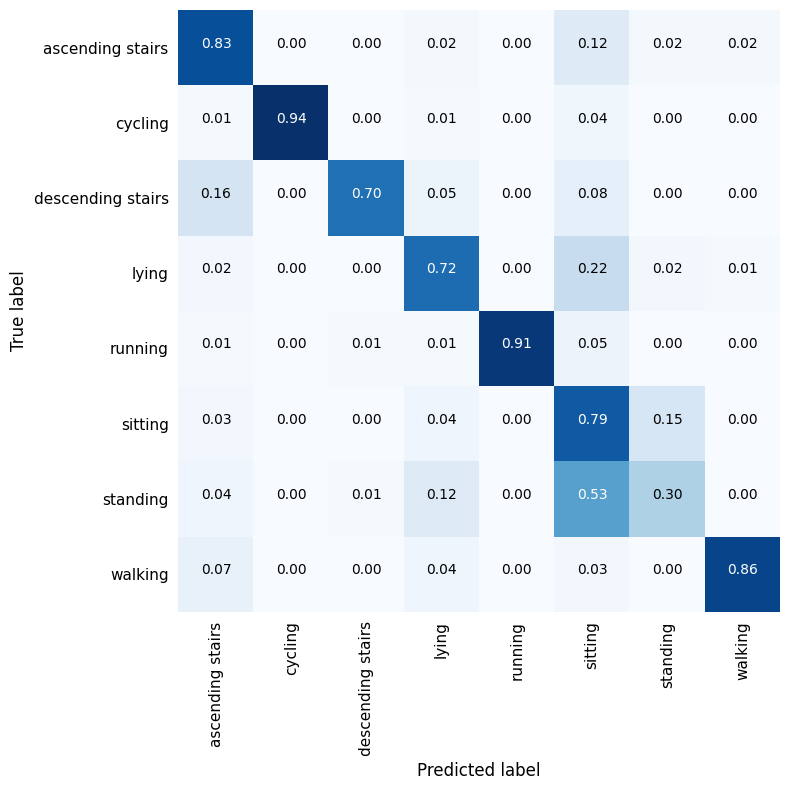

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

cm = [np.zeros([len(classes)]) for _ in range(len(classes))]

n_epochs = 50
batch_size = 200

# get validation data
samples_fine_tuning, samples_val, ohe_labels_fine_tuning, ohe_labels_val = train_test_split(samples[fine_tuning], ohe_labels[fine_tuning], test_size=0.1)


print("Creating the model...")
simclr_model = tf.keras.models.load_model(f"{project_path}/Lab6/simclr_model")
full_classifier = create_full_classification_model_from_base_model(simclr_model)


print("\nTraining...")
history = full_classifier.fit(x=samples_fine_tuning,
                  y=ohe_labels_fine_tuning,
                  batch_size = batch_size,
                  epochs = n_epochs,
                  validation_data = (samples_val, ohe_labels_val),
                  callbacks=[early_stopping])


print("\nPredicting...")
y_preds = full_classifier.predict(samples[test])

y_preds = np.argmax(y_preds, axis=1)
y_targets = np.argmax(ohe_labels[test], axis=1)


print("\nClassification Report:")
print(classification_report(y_targets, y_preds, target_names=classes, labels=np.array([i for i in range(len(classes))]), digits=4, zero_division=0))


print("\nConfusion Matrix:")
s_preds, s_targets = [], []
for el in y_preds: s_preds.append(classes[el])
for el in y_targets: s_targets.append(classes[el])

cm += confusion_matrix(s_targets, s_preds, labels=classes)
cm = cm.astype(np.int32)

plot_confusion_matrix(cm, classes)


## Exercises

1. Implement the Early Stopping technique in the function that trains Sim-CLR

2. Try different percentages for the fine-tuning set for both the AutoEncoder and the Sim-CLR solutions. When Self-supervised learning is not effective anymore?

3. Try different transformation functions with Sim-CLR

In [ ]:
# Your turn!